In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import requests
# Import visualization library
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline


torch.__version__

'2.1.2+cpu'

In [2]:
# Check to see if we have a GPU to use for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('A {} device was detected.'.format(device))


if device=='cuda':
    print (torch.cuda.get_device_name(device=device))

A cpu device was detected.


In [3]:
# Use Pandas to do our dataprocessing on the dataset
api_url= "https://debt-api-4301881a2ff8.herokuapp.com/loan/get_all"
res = requests.get(api_url)
df = pd.DataFrame(res.json()["data"])
test_data = pd.read_csv('test.csv')

In [4]:
df.head()

,loan_id,gender,married,dependents,education,self_employed,applicantIncome,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
0,LP001002,Male,No,0,Graduate,No,5849,0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0,141.0,360.0,1.0,Urban,Y


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_id             614 non-null    object 
 1   gender              601 non-null    object 
 2   married             611 non-null    object 
 3   dependents          599 non-null    object 
 4   education           614 non-null    object 
 5   self_employed       582 non-null    object 
 6   applicantIncome     614 non-null    int64  
 7   coapplicant_income  614 non-null    object 
 8   loan_amount         592 non-null    float64
 9   loan_amount_term    600 non-null    float64
 10  credit_history      564 non-null    float64
 11  property_area       614 non-null    object 
 12  loan_status         614 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 62.5+ KB


In [6]:
df['coapplicant_income'] = df['coapplicant_income'].astype(float)
print(df['coapplicant_income'].dtype)
df['applicantIncome'] = df['applicantIncome'].astype(float)
print(df['coapplicant_income'].dtype)

float64
float64


In [7]:
df.dtypes

loan_id                object
gender                 object
married                object
dependents             object
education              object
self_employed          object
applicantIncome       float64
coapplicant_income    float64
loan_amount           float64
loan_amount_term      float64
credit_history        float64
property_area          object
loan_status            object
dtype: object

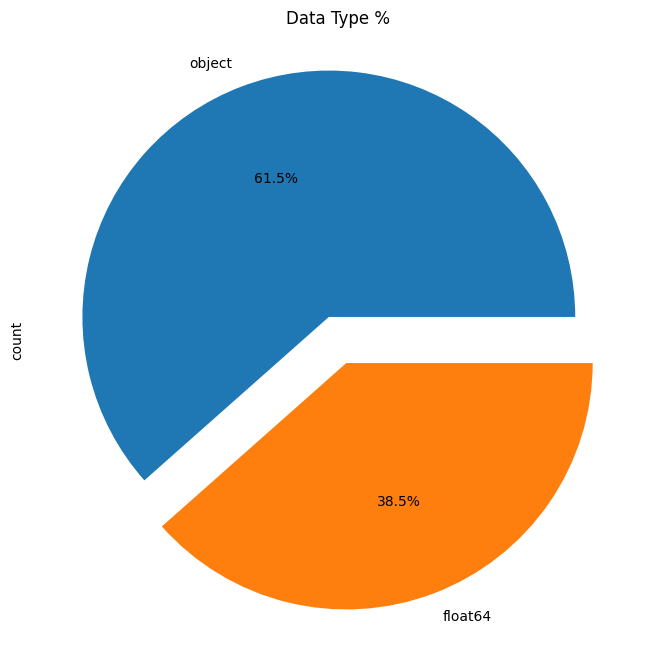

In [8]:
plt.figure(figsize=(8, 8))
explode_values = [0.1] * len(df.dtypes.unique())
df.dtypes.value_counts().plot.pie(explode=explode_values, autopct='%1.1f%%')

plt.title('Data Type %')
plt.show()


In [9]:
df.isnull().sum()

loan_id                0
gender                13
married                3
dependents            15
education              0
self_employed         32
applicantIncome        0
coapplicant_income     0
loan_amount           22
loan_amount_term      14
credit_history        50
property_area          0
loan_status            0
dtype: int64

In [10]:
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])
df['married'] = df['married'].fillna(df['married'].mode()[0])
df['dependents'] = df['dependents'].fillna(df['dependents'].mode()[0])
df['self_employed'] = df['self_employed'].fillna(df['self_employed'].mode()[0])

In [11]:
df['loan_amount'] = df['loan_amount'].fillna(df['loan_amount'].mean())
df['loan_amount_term'] = df['loan_amount_term'].fillna(df['loan_amount_term'].mean())
df['credit_history'] = df['credit_history'].fillna(df['credit_history'].mean())

In [12]:
features = ['gender', 'married', 'dependents', 'education', 'self_employed',
            'applicantIncome', 'coapplicant_income', 'loan_amount', 'loan_amount_term',
            'credit_history', 'property_area']

X = df[features]
y = df['loan_status']

In [13]:
X = pd.get_dummies(X)
X.head()

,applicantIncome,coapplicant_income,loan_amount,loan_amount_term,credit_history,gender_Female,gender_Male,married_No,married_Yes,dependents_0,dependents_1,dependents_2,dependents_3+,education_Graduate,education_Not Graduate,self_employed_No,self_employed_Yes,property_area_Rural,property_area_Semiurban,property_area_Urban
0,5849.0,0.0,146.412162,360.0,1.0,False,True,True,False,True,False,False,False,True,False,True,False,False,False,True
1,4583.0,1508.0,128.000000,360.0,1.0,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False
2,3000.0,0.0,66.000000,360.0,1.0,False,True,False,True,True,False,False,False,True,False,False,True,False,False,True
3,2583.0,2358.0,120.000000,360.0,1.0,False,True,False,True,True,False,False,False,False,True,True,False,False,False,True
4,6000.0,0.0,141.000000,360.0,1.0,False,True,True,False,True,False,False,False,True,False,True,False,False,False,True


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.head()

,applicantIncome,coapplicant_income,loan_amount,loan_amount_term,credit_history,gender_Female,gender_Male,married_No,married_Yes,dependents_0,dependents_1,dependents_2,dependents_3+,education_Graduate,education_Not Graduate,self_employed_No,self_employed_Yes,property_area_Rural,property_area_Semiurban,property_area_Urban
83,6000.0,2250.0,265.0,360.0,0.842199,False,True,False,True,True,False,False,False,True,False,True,False,False,True,False
90,2958.0,2900.0,131.0,360.0,1.000000,False,True,False,True,True,False,False,False,True,False,True,False,False,True,False
227,6250.0,1695.0,210.0,360.0,1.000000,False,True,False,True,False,False,True,False,True,False,True,False,False,True,False
482,2083.0,3150.0,128.0,360.0,1.000000,False,True,False,True,True,False,False,False,True,False,True,False,False,True,False
464,4166.0,0.0,98.0,360.0,0.000000,False,True,True,False,True,False,False,False,True,False,True,False,False,True,False


In [16]:
y_train.head()

83     N
90     Y
227    Y
482    Y
464    N
Name: loan_status, dtype: object

In [17]:
X_train.shape, X_val.shape,y_train.shape, y_val.shape

((491, 20), (123, 20), (491,), (123,))

In [18]:
y_val_binary = y_val.map({'N': 0, 'Y': 1})

In [19]:
y_val.dtype

dtype('O')

In [20]:
import pickle


knn_model = pickle.load(open('./KNeighborsClassifier.pkl', 'rb'))
lr_model = pickle.load(open('LogisticRegression.pkl', 'rb'))
nb_model = pickle.load(open('./GaussianNaiveBayes.pkl', 'rb'))
rf_model = pickle.load(open('./random_forest_model.pkl', 'rb'))
dt_model = pickle.load(open('./DecisionTreeClassifier.pkl', 'rb'))
rf_regressor_model = pickle.load(open('./random_forest_regressor.pkl', 'rb'))


In [21]:
knn_predictions = knn_model.predict(X_val)[0]
lr_predictions = lr_model.predict(X_val)[0]
nb_prediction_str = nb_model.predict(X_val)[0]
nb_prediction_numeric = 1 if nb_prediction_str == 'Y' else 0
nb_predictions = nb_prediction_numeric > 0.5
rf_predictions = rf_model.predict(X_val)[0]
dt_predictions = dt_model.predict(X_val)[0]
rf_regressor_predictions = (rf_regressor_model.predict(X_val)[0])>0.5


In [22]:
# Assuming y_val_numeric is the converted numerical format of true labels
y_val_numeric = y_val.map({'Y': 1, 'N': 0})


In [23]:
knn_predictions = knn_model.predict(X_val)
knn_predictions_numeric = [1 if pred == 'Y' else 0 for pred in knn_predictions]
knn_accuracy = accuracy_score(y_val_numeric, knn_predictions_numeric)

# Logistic Regression model
lr_predictions = lr_model.predict(X_val)
lr_predictions_numeric = [1 if pred == 'Y' else 0 for pred in lr_predictions]
lr_accuracy = accuracy_score(y_val_numeric, lr_predictions_numeric)

# Naive Bayes model
nb_predictions_str = nb_model.predict(X_val)
nb_predictions_numeric = [1 if pred == 'Y' else 0 for pred in nb_predictions_str]
nb_accuracy = accuracy_score(y_val_numeric, nb_predictions_numeric)

# Random Forest model
rf_predictions = rf_model.predict(X_val)
rf_predictions_numeric = [1 if pred == 'Y' else 0 for pred in rf_predictions]
rf_accuracy = accuracy_score(y_val_numeric, rf_predictions_numeric)

# Decision Tree model
dt_predictions = dt_model.predict(X_val)
dt_predictions_numeric = [1 if pred == 'Y' else 0 for pred in dt_predictions]
dt_accuracy = accuracy_score(y_val_numeric, dt_predictions_numeric)

# Random Forest Regressor model
rf_regressor_predictions = (rf_regressor_model.predict(X_val) > 0.5).astype(int)
rf_regressor_accuracy = accuracy_score(y_val_numeric, rf_regressor_predictions)

# Print or use the accuracies as needed
print("KNN Classifier Accuracy:", knn_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)
print("Random Forest Regressor Accuracy:", rf_regressor_accuracy)

KNN Classifier Accuracy: 0.6097560975609756
Logistic Regression Accuracy: 0.7886178861788617
Naive Bayes Accuracy: 0.7804878048780488
Random Forest Accuracy: 0.7723577235772358
Decision Tree Accuracy: 0.7967479674796748
Random Forest Regressor Accuracy: 0.7886178861788617


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming X_val is your validation data and y_val is your true labels

# KNN model
knn_predictions = knn_model.predict(X_val)
knn_predictions_numeric = [1 if pred == 'Y' else 0 for pred in knn_predictions]
knn_accuracy = accuracy_score(y_val_numeric, knn_predictions_numeric)
knn_precision = precision_score(y_val_numeric, knn_predictions_numeric, average='weighted')
knn_recall = recall_score(y_val_numeric, knn_predictions_numeric, average='weighted')
knn_f1 = f1_score(y_val_numeric, knn_predictions_numeric, average='weighted')
knn_classification_report = classification_report(y_val_numeric, knn_predictions_numeric)

# Print or use the metrics as needed
print("KNN Classifier Metrics:")
print("Accuracy:", knn_accuracy)
print("Precision:", knn_precision)
print("Recall:", knn_recall)
print("F1 Score:", knn_f1)
print("Classification Report:\n", knn_classification_report)


KNN Classifier Metrics:
Accuracy: 0.6097560975609756
Precision: 0.5380909364649201
Recall: 0.6097560975609756
F1 Score: 0.544620009663046
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.12      0.17        43
           1       0.65      0.88      0.74        80

    accuracy                           0.61       123
   macro avg       0.49      0.50      0.46       123
weighted avg       0.54      0.61      0.54       123



In [26]:
# Logistic Regression model
lr_predictions = lr_model.predict(X_val)
lr_predictions_numeric = [1 if pred == 'Y' else 0 for pred in lr_predictions]
lr_accuracy = accuracy_score(y_val_numeric, lr_predictions_numeric)
lr_precision = precision_score(y_val_numeric, lr_predictions_numeric, average='weighted')
lr_recall = recall_score(y_val_numeric, lr_predictions_numeric, average='weighted')
lr_f1 = f1_score(y_val_numeric, lr_predictions_numeric, average='weighted')
lr_classification_report = classification_report(y_val_numeric, lr_predictions_numeric)

# Print or use the metrics as needed
print("\nLogistic Regression Metrics:")
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 Score:", lr_f1)
print("Classification Report:\n", lr_classification_report)


Logistic Regression Metrics:
Accuracy: 0.7886178861788617
Precision: 0.8252526249958856
Recall: 0.7886178861788617
F1 Score: 0.7614910090194872
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



In [27]:
# Naive Bayes model
nb_predictions_str = nb_model.predict(X_val)
nb_predictions_numeric = [1 if pred == 'Y' else 0 for pred in nb_predictions_str]
nb_accuracy = accuracy_score(y_val_numeric, nb_predictions_numeric)
nb_precision = precision_score(y_val_numeric, nb_predictions_numeric, average='weighted')
nb_recall = recall_score(y_val_numeric, nb_predictions_numeric, average='weighted')
nb_f1 = f1_score(y_val_numeric, nb_predictions_numeric, average='weighted')
nb_classification_report = classification_report(y_val_numeric, nb_predictions_numeric)

# Print or use the metrics as needed
print("\nNaive Bayes Metrics:")
print("Accuracy:", nb_accuracy)
print("Precision:", nb_precision)
print("Recall:", nb_recall)
print("F1 Score:", nb_f1)
print("Classification Report:\n", nb_classification_report)


Naive Bayes Metrics:
Accuracy: 0.7804878048780488
Precision: 0.8071749940800379
Recall: 0.7804878048780488
F1 Score: 0.7542126006740163
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.42      0.57        43
           1       0.76      0.97      0.85        80

    accuracy                           0.78       123
   macro avg       0.83      0.70      0.71       123
weighted avg       0.81      0.78      0.75       123



In [28]:
# Random Forest model
rf_predictions = rf_model.predict(X_val)
rf_predictions_numeric = [1 if pred == 'Y' else 0 for pred in rf_predictions]
rf_accuracy = accuracy_score(y_val_numeric, rf_predictions_numeric)
rf_precision = precision_score(y_val_numeric, rf_predictions_numeric, average='weighted')
rf_recall = recall_score(y_val_numeric, rf_predictions_numeric, average='weighted')
rf_f1 = f1_score(y_val_numeric, rf_predictions_numeric, average='weighted')
rf_classification_report = classification_report(y_val_numeric, rf_predictions_numeric)

# Print or use the metrics as needed
print("\nRandom Forest Metrics:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)
print("Classification Report:\n", rf_classification_report)


Random Forest Metrics:
Accuracy: 0.7723577235772358
Precision: 0.7906447131698207
Recall: 0.7723577235772358
F1 Score: 0.746990306441526
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.42      0.56        43
           1       0.75      0.96      0.85        80

    accuracy                           0.77       123
   macro avg       0.81      0.69      0.70       123
weighted avg       0.79      0.77      0.75       123



In [29]:
# Decision Tree model
dt_predictions = dt_model.predict(X_val)
dt_predictions_numeric = [1 if pred == 'Y' else 0 for pred in dt_predictions]
dt_accuracy = accuracy_score(y_val_numeric, dt_predictions_numeric)
dt_precision = precision_score(y_val_numeric, dt_predictions_numeric, average='weighted')
dt_recall = recall_score(y_val_numeric, dt_predictions_numeric, average='weighted')
dt_f1 = f1_score(y_val_numeric, dt_predictions_numeric, average='weighted')
dt_classification_report = classification_report(y_val_numeric, dt_predictions_numeric)

# Print or use the metrics as needed
print("\nDecision Tree Metrics:")
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)
print("Classification Report:\n", dt_classification_report)


Decision Tree Metrics:
Accuracy: 0.7967479674796748
Precision: 0.8309692951298445
Recall: 0.7967479674796748
F1 Score: 0.7724190746981632
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.44      0.60        43
           1       0.77      0.99      0.86        80

    accuracy                           0.80       123
   macro avg       0.86      0.71      0.73       123
weighted avg       0.83      0.80      0.77       123



In [30]:
# Random Forest Regressor model
rf_regressor_predictions = (rf_regressor_model.predict(X_val) > 0.5).astype(int)
rf_regressor_accuracy = accuracy_score(y_val_numeric, rf_regressor_predictions)
rf_regressor_precision = precision_score(y_val_numeric, rf_regressor_predictions, average='weighted')
rf_regressor_recall = recall_score(y_val_numeric, rf_regressor_predictions, average='weighted')
rf_regressor_f1 = f1_score(y_val_numeric, rf_regressor_predictions, average='weighted')
rf_regressor_classification_report = classification_report(y_val_numeric, rf_regressor_predictions)

# Print or use the metrics as needed
print("\nRandom Forest Regressor Metrics:")
print("Accuracy:", rf_regressor_accuracy)
print("Precision:", rf_regressor_precision)
print("Recall:", rf_regressor_recall)
print("F1 Score:", rf_regressor_f1)
print("Classification Report:\n", rf_regressor_classification_report)


Random Forest Regressor Metrics:
Accuracy: 0.7886178861788617
Precision: 0.8252526249958856
Recall: 0.7886178861788617
F1 Score: 0.7614910090194872
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

